In [5]:
import torch
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt

- x : (batch_size, max_length) 

- tokens_id in x between 0 and vocab_size

- Embedd(x) : (batch_size, max_length, model_dim)

- K : (model_dim, dk)
- Kx : (batch_size, max_length, dk)

- Q : (model_dim, dk)
- Qx : (batch_size, max_length, dk)

- Qx*Kx^T (batch_size, max_length)
- V : (dk, dv)
- Vx : (batch_size, max_length, dv)





In [30]:
class Embedding(nn.Module):
    def __init__(self,  batch_size, model_dim, max_length, n_embedding):
        super().__init__()
        self.max_length = max_length
        self.batch_size = batch_size
        self.model_dim = model_dim
        self.n_embedding = n_embedding
        self.embedding = torch.nn.Embedding(num_embeddings=n_embedding, embedding_dim=model_dim)
        self.pos_encoding = PositionalEncoding(batch_size=batch_size, model_dim=model_dim, max_length=max_length)
        pass
    
    def forward(self, x):
        x = self.embedding(x) + self.pos_encoding(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, batch_size, model_dim, max_length):
        super().__init__()
        self.model_dim = model_dim
        self.max_length = max_length
        self.batch_size = batch_size
        self.compute()

    def SinPos(self, i: int, pos: int):
        if i % 2 == 0:
            return np.sin(pos / 10000 ** (2 * i / self.model_dim))
        else:
            return np.cos(pos / 10000 ** (2 * i / self.model_dim))

    def compute(self):
        Mat = torch.Tensor([[self.SinPos(i, pos) for i in range(self.model_dim)] for pos in range(self.max_length)])
        self.Mat = Mat.expand(self.batch_size, -1, -1)

    
    def forward(self, x):
        with torch.no_grad():
            return self.Mat



In [118]:
class SingleHeadAttention(nn.Module):
    def __init__(self, dk:int, dv:int, model_dim:int):
        super().__init__()
        self.dk = dk
        self.dv = dv
        self.model_dim = model_dim
        self.K = nn.Linear(in_features=model_dim, out_features=dk)
        self.Q = nn.Linear(in_features=model_dim, out_features=dk)
        self.V = nn.Linear(in_features=model_dim, out_features=dv)

    def forward(self, x:torch.Tensor):
        Kx = self.K(x)
        Qx = self.Q(x)
        Vx = self.V(x)
        QK = torch.sum(Kx *Qx, dim=-1)/np.sqrt(self.dk)
        QK = torch.softmax(QK, dim=-1)
        QK = QK.unsqueeze(-1)
        QK = QK.expand(-1, -1, self.dv)
        return QK*Vx
    
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads : int, dk:int, dv:int, model_dim:int):
        super().__init__()
        assert num_heads * dv == model_dim, "num_heads * dv should be equal to the model dim"
        self.attention_heads = nn.ModuleList([SingleHeadAttention(dk, dv, model_dim) for _ in range(num_heads)])
        self.WO = nn.Linear(in_features=num_heads*dv, out_features=model_dim)  
    
    def forward(self, x:torch.Tensor):
        outputs = []
        for head in self.attention_heads:
            outputs.append(head(x))
        x = torch.cat(outputs,dim=-1)
        x = self.WO(x)
        return x

In [123]:
class EncoderBlock(nn.Module):
    def __init__(self, num_heads, dk, dv, model_dim):
        super().__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, dk=dk, dv=dv, model_dim=model_dim)
        self.layerNorm = nn.LayerNorm(normalized_shape=model_dim)
        self.ff = nn.Sequential(
            nn.Linear(in_features=model_dim, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=model_dim)
        )

    
    def forward(self, x):
        attention = self.attention(x)
        x = self.layerNorm(x + attention)
        feedforward = self.ff(x)
        x = self.layerNorm(x + feedforward)
        return x


class Encoder(nn.Module):
    def __init__(self, num_heads, dk, dv, model_dim, num_encoders):
        super().__init__()
        encoders_list = [EncoderBlock(num_heads, dk, dv, model_dim) for _ in range(num_encoders)]
        self.encoders = nn.Sequential(*encoders_list)

    def forward(self, x):
        x = self.encoders(x)
        return x


In [124]:
class Transformers(nn.Module):
    def __init__(self, encoder, decoder, linear, softmax, batch_size, model_dim, max_length, vocab_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax = nn.Softmax()
        self.linear = linear
        self.embedding = Embedding(batch_size=batch_size, model_dim=model_dim, max_length=max_length, n_embedding=vocab_size)
        pass
    
    def forward(self, x):
        x = self.embedding(x)
        return x



class Decoder(nn.Module):
    def __init__(self, attention):
        super().__init__()
        pass
    





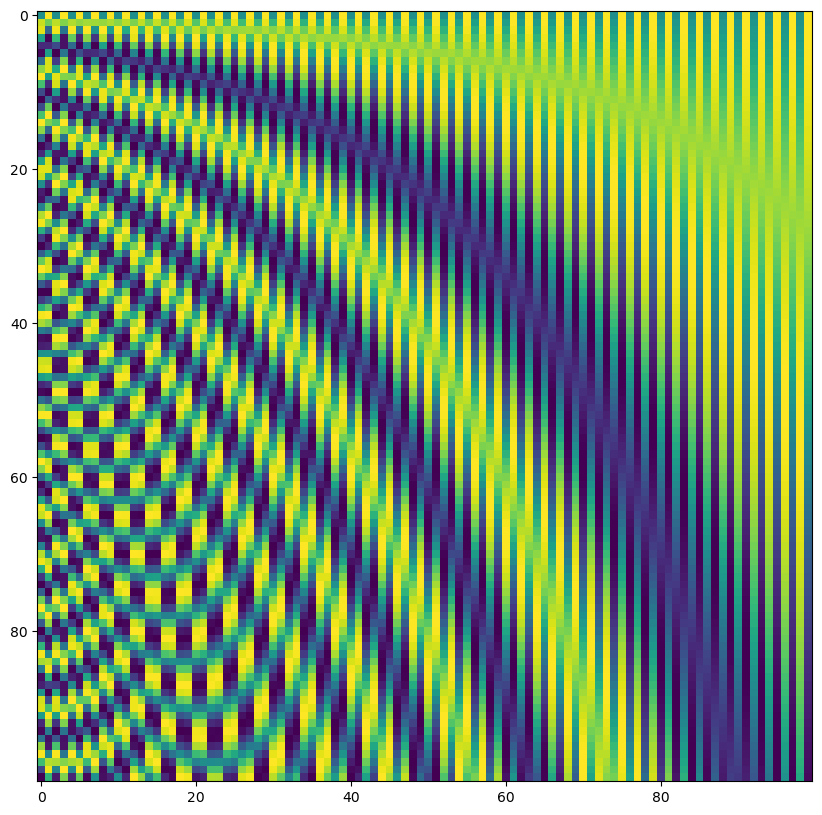

In [116]:
MyPositionalEncoding = PositionalEncoding(batch_size=batch_size, model_dim=model_dim, max_length=max_length)

plt.figure(figsize=(10, 10))
plt.imshow(MyPositionalEncoding.Mat[0, :100, :100], aspect="auto")

In [125]:
batch_size = 16
model_dim = 512
max_length = 100
vocab_size = 32000

x = torch.randint(0, vocab_size, (batch_size, max_length))


MyEmbedding = Embedding(batch_size=batch_size, model_dim=model_dim, max_length=max_length, n_embedding=vocab_size)
# MyMultiHeadAttention = MultiHeadAttention(num_heads=8, dk=64, dv=64, model_dim=512)
# MyEncoderBlock = EncoderBlock(num_heads=8, dk=64, dv=64, model_dim=512)
MyEncoder = Encoder(num_heads=8, dk=64, dv=64, model_dim=512, num_encoders=6)
x = MyEmbedding(x)
x = MyEncoder(x)
x.shape

torch.Size([16, 100, 512])

In [134]:
def print_model_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')

print_model_parameters(MyEmbedding)
# 
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in MyEmbedding.parameters() if p.requires_grad)
total_params_no_grad = sum(p.numel() for p in MyEmbedding.parameters() if p.requires_grad)

print(f'Total number of trainable parameters: {total_params_no_grad}')
print(f'Total number parameters: {total_params}')

embedding.weight: 16384000 parameters
Total number of trainable parameters: 16384000
Total number parameters: 16384000


In [135]:
import torch
import numpy as np

# Define dimensions
batch_size = 2
seq_length = 3
model_dim = 4
dk = 4
dv = 4

# Generate random matrices
Qx = torch.randn(batch_size, seq_length, model_dim)
Kx = torch.randn(batch_size, seq_length, model_dim)
Vx = torch.randn(batch_size, seq_length, dv)

# Implementation 1: Dot product attention
QK_dot_product = torch.matmul(Qx, Kx.transpose(-2, -1)) / np.sqrt(dk)
QK_dot_product = torch.softmax(QK_dot_product, dim=-1)
output_dot_product = torch.matmul(QK_dot_product, Vx)

# Implementation 2: Element-wise multiplication and summation
QK_elementwise = torch.sum(Kx * Qx, dim=-1) / np.sqrt(dk)
QK_elementwise = torch.softmax(QK_elementwise, dim=-1)
QK_elementwise = QK_elementwise.unsqueeze(-1)
QK_elementwise = QK_elementwise.expand(-1, -1, dv)
output_elementwise = QK_elementwise * Vx

# Print results
print("Output (Dot Product):")
print(output_dot_product)
print("\nOutput (Element-wise):")
print(output_elementwise)

Output (Dot Product):
tensor([[[ 0.8135, -0.4580,  0.8029,  0.1411],
         [-0.3034, -0.2345,  0.2389,  0.1042],
         [ 0.6104, -0.1512,  0.4783, -0.0657]],

        [[-0.2787,  0.9954,  0.8464, -0.2801],
         [-0.2337,  1.0036,  0.7845, -0.1865],
         [-0.2645,  0.9221,  0.8332, -0.2380]]])

Output (Element-wise):
tensor([[[ 0.8075, -0.5717,  0.8141,  0.2876],
         [ 0.2791, -0.0066,  0.1415, -0.0585],
         [-0.3046, -0.0824,  0.0058,  0.0681]],

        [[ 0.0791,  0.2676,  0.0383,  0.2675],
         [-0.3081,  0.4092,  0.7134, -0.4355],
         [-0.0153,  0.1695,  0.0602, -0.0146]]])
